# Full Dependencies Analysis
This notebook explores the recursive dependencies exported in full_dataset_dependencies.json

Requirements: install networkx, matplotlib and ipywidgets via pip

## Setup and Load

In [6]:
import json
import matplotlib.pyplot as plt
import pandas as pd

INPUT_FILE_NAME = "full_dataset_dependencies.json"
INPUT_DIR = "output"

# Load the direct dependencies data
file_path = f"{INPUT_DIR}/{INPUT_FILE_NAME}"
with open(file_path, 'r') as file:
    full_dependencies = json.load(file)

# Convert to a DataFrame
dependency_list = []
for dataset, dependencies in full_dependencies.items():
    for dep in dependencies:
        dependency_list.append({"Dataset": dataset, "Dependency": dep})

df = pd.DataFrame(dependency_list)


## Basic Data Exploration

In [7]:
# Display the first few rows of the DataFrame
print(df.head())

              Dataset               Dependency
0  QI_AF_CASE_FINDING  PH_D_ORGANIZATION_CLASS
1  QI_AF_CASE_FINDING     NSPL_POSTCODE_LOOKUP
2  QI_AF_CASE_FINDING      LSOA21_WARD22_LAD22
3  QI_AF_CASE_FINDING                 ONTOLOGY
4  QI_AF_CASE_FINDING     COVID_GPS_DSA_SIGNED


In [8]:
# DataFrame shape (number of rows and columns)
print(f"DataFrame Shape: {df.shape}")

# Column data types
print(f"Data Types:\n{df.dtypes}")

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing Values:\n{missing_values}")


DataFrame Shape: (32996, 2)
Data Types:
Dataset       object
Dependency    object
dtype: object
Missing Values:
Dataset       0
Dependency    0
dtype: int64


## Unique Dataset Count

In [9]:
# Unique Datasets and Dependencies
unique_datasets = df['Dataset'].nunique()
unique_dependencies = df['Dependency'].nunique()
print(f"Unique Datasets: {unique_datasets}")
print(f"Unique Dependencies: {unique_dependencies}")

Unique Datasets: 692
Unique Dependencies: 787


## Frequent dependencies

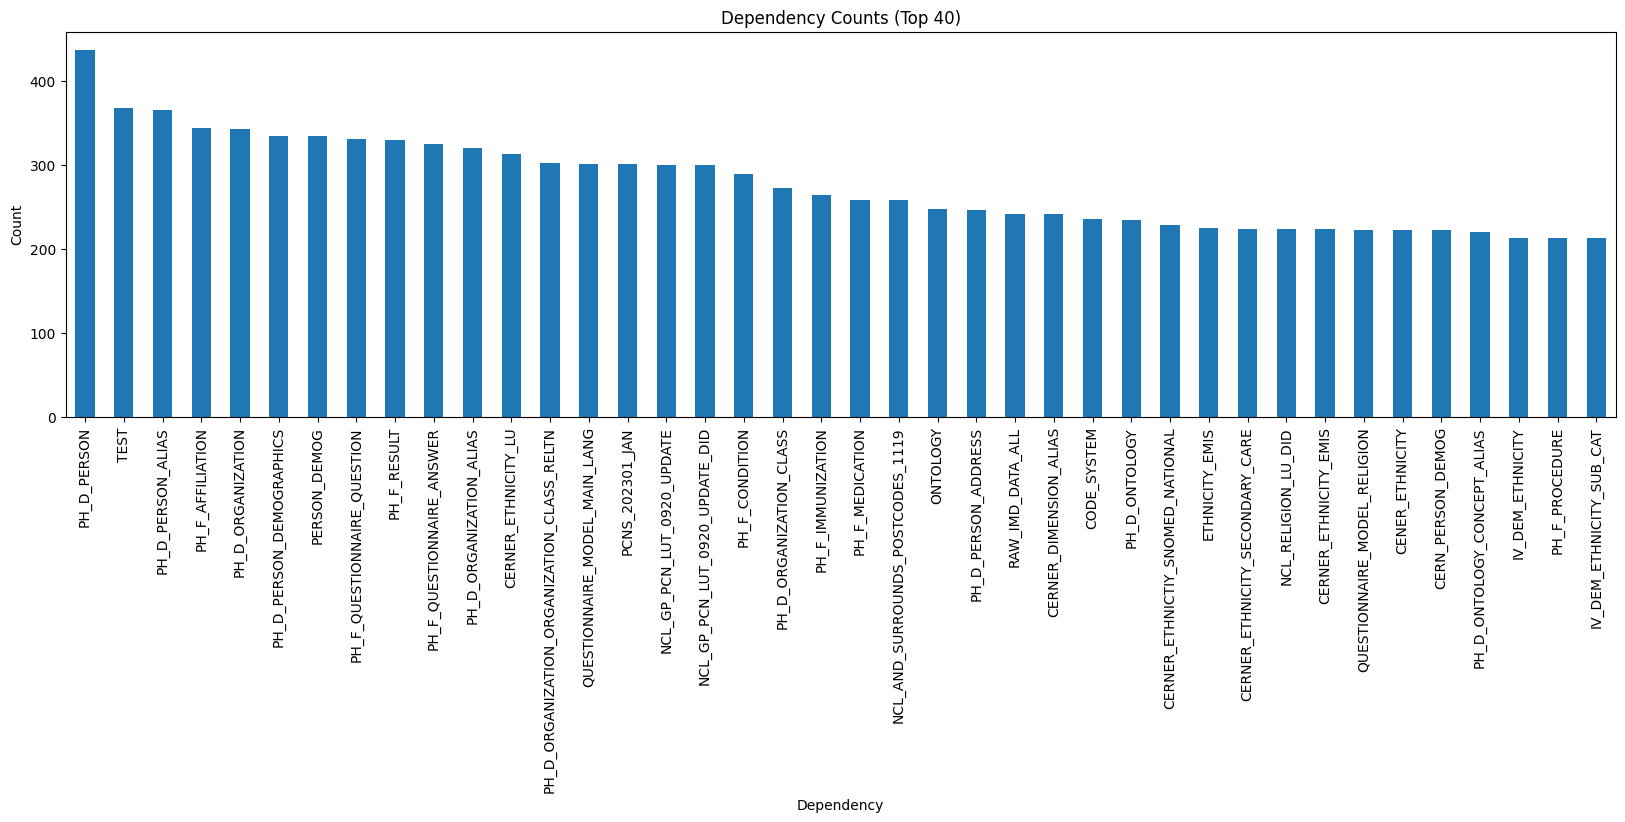

In [10]:
dependency_freq = df['Dependency'].value_counts().head(40)

plt.figure(figsize=(20, 5))
dependency_freq.plot(kind='bar')
plt.xlabel('Dependency')
plt.ylabel('Count')
plt.title('Dependency Counts (Top 40)')

# Set x-axis tick labels and rotation
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [11]:
# Frequency of dependencies
dependency_freq = df['Dependency'].value_counts().head(20)
print("Most frequent dependencies:\n", dependency_freq)

Most frequent dependencies:
 Dependency
PH_D_PERSON                                   437
TEST                                          368
PH_D_PERSON_ALIAS                             366
PH_F_AFFILIATION                              344
PH_D_ORGANIZATION                             343
PH_D_PERSON_DEMOGRAPHICS                      335
PERSON_DEMOG                                  335
PH_F_QUESTIONNAIRE_QUESTION                   331
PH_F_RESULT                                   330
PH_F_QUESTIONNAIRE_ANSWER                     325
PH_D_ORGANIZATION_ALIAS                       320
CERNER_ETHNICITY_LU                           313
PH_D_ORGANIZATION_ORGANIZATION_CLASS_RELTN    302
QUESTIONNAIRE_MODEL_MAIN_LANG                 301
PCNS_202301_JAN                               301
NCL_GP_PCN_LUT_0920_UPDATE                    300
NCL_GP_PCN_LUT_0920_UPDATE_DID                300
PH_F_CONDITION                                289
PH_D_ORGANIZATION_CLASS                       273
PH_F_IMMUN

## Datasets that have no dependents
This is datasets that have no other datasets that rely on it

In [12]:
def find_datasets_with_no_dependents(full_dependencies):
    all_datasets = set(full_dependencies.keys())
    datasets_with_dependents = set()

    # Identifying all datasets that are dependencies
    for dependencies in full_dependencies.values():
        datasets_with_dependents.update(dependencies)

    # Datasets with no dependents are those in all_datasets but not in datasets_with_dependents
    datasets_with_no_dependents = all_datasets - datasets_with_dependents

    # Sort the list alphabetically
    return sorted(list(datasets_with_no_dependents))

# Use the function with the full_dependencies dictionary
datasets_with_no_dependents = find_datasets_with_no_dependents(full_dependencies)

print(f"Datasets with no dependents: {len(datasets_with_no_dependents)} of {unique_datasets} total datasets ({len(datasets_with_no_dependents)/unique_datasets:.0%})")
for dataset in datasets_with_no_dependents:
    print(dataset)

Datasets with no dependents: 209 of 692 total datasets (30%)
AA_CASEFINDING_TEST
AA_HASH_TEST
AA_TEST_NCL
AE_ATTENDANCES_THREE
ASC_ALL_BOROUGHS_HIST
ASC_PERSONNEL_LIST
ASC_TEST1
ASC_TRAINING_DATASET
ASC_TRAINING_DATA_OR
BASETEST
CERNER_CDV_CLINICALRECORDHISTORY
CERNER_DAILY_COUNTS
CERNER_DATA_MONITORING
CERNER_DI_CLINICAL_DATA_VALIDATI
CERNER_DI_CODE_COMPARE
CERNER_DI_DATALINEAGE
CERNER_DI_DM_DELETE
CERNER_DI_DS_RELEASEDETAILS
CERNER_DI_GPTRENDS1
CERNER_DI_GPTRENDS2
CERNER_DI_MASTER_REFERENCE
CERNER_DI_PCA
CERNER_EFI_DM_HISTORIC
CERNER_EMIS_HEI_ORG_RELTN
CERNER_EMIS_HEI_PRSNL_RELTN
CERNER_ETHNICITY_FLAGS_AGRREGATE
CERNER_ETHNICITY_METRICS_FLAGS
CERNER_HOURLY_TRENDS
CERNER_MPM_ALIAS_QUEUE
CERNER_PP_DEM_ETHNICITY
CERNER_PP_ENC_SUMMARY
CERNER_PP_LTC_SUMMARY
CERNER_PP_RISK_BMI_DID
CERNER_PP_RISK_LONGITUDINAL_DID
CERNER_UC_ENCOUNTERS
CERN_ROW_LEVEL_SECURITY_GP
CERN_SENTINEL_ALL_SOLUTIONS
CI_95_PCT_CALCS
CI_CASEFINDING_DEMOG_DEID
CI_DQ_INCORRECT_ORDER
CI_DQ_MAIN_DEV
CI_DQ_MAIN_P2
CI_DQ_QOF_T

## Independent Datasets

In [13]:
# Define the variable independent_datasets
independent_datasets = df[df['Dependency'].isnull()]

dataset_list = []
for dataset in independent_datasets['Dataset'].unique():
    dataset_list.append(dataset)

print(f"Total Independent Datasets: {len(dataset_list)}")

for dataset in dataset_list:
    print(dataset)


Total Independent Datasets: 0


## Circular Dependency Detection
Circular dependencies occur when a dataset indirectly depends on itself, which can lead to issues.

In [14]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for dataset, dependencies in full_dependencies.items():
    for dependency in dependencies:
        if dataset != dependency:  # Exclude self-references
            G.add_edge(dataset, dependency)

# Detect circular dependencies (simple cycles)
circular_dependencies = list(nx.simple_cycles(G))

# Print circular dependencies, if any
if circular_dependencies:
    print("Circular dependencies detected:")
    for cycle in circular_dependencies:
        # Include the start node at the end for full cycle representation
        cycle.append(cycle[0])
        
        if len(cycle) > 6:  # Limit display for long cycles
            cycle_summary = f"{cycle[0]} -> ... -> {cycle[-2]} -> {cycle[0]} (cycle of length {len(cycle)-1})"
        else:
            cycle_summary = " -> ".join(cycle)
        
        print(cycle_summary)
else:
    print("No circular dependencies detected.")


Circular dependencies detected:
FRAILTY_DEV_DASHBOARD_TEST_2 -> FRAILTY_ENCOUNTERS_TEST -> FRAILTY_DEV_DASHBOARD_TEST_2
CERN_SENTINEL_LATEST_DATA -> CERN_SENTINEL_ALL_MASTER -> CERN_SENTINEL_ALL_DATA_COMBINED -> CERN_SENTINEL_LATEST_DATA
CERN_SENTINEL_LATEST_DATA -> CERN_SENTINEL_ALL_MASTER -> CERN_SENTINEL_LATEST_DATA
CERN_SENTINEL_LATEST_DATA -> CERN_SENTINEL_ALL_DATA_COMBINED -> CERN_SENTINEL_LATEST_DATA
CERN_SENTINEL_LATEST_DATA -> CERN_SENTINEL_ALL_DATA_COMBINED -> CERN_SENTINEL_ALL_MASTER -> CERN_SENTINEL_LATEST_DATA
CERN_SENTINEL_ALL_DATA_COMBINED -> CERN_SENTINEL_ALL_MASTER -> CERN_SENTINEL_ALL_DATA_COMBINED
EMPI_TODAY -> EMPI_LOG -> EMPI_TODAY
EMPI_TODAY -> EMPI_LOG -> EMPI_COMBINED -> EMPI_TODAY
EMPI_TODAY -> EMPI_COMBINED -> EMPI_TODAY
EMPI_TODAY -> EMPI_COMBINED -> EMPI_LOG -> EMPI_TODAY
EMPI_COMBINED -> EMPI_LOG -> EMPI_COMBINED
CERNER_DI_UNMAPPED_HOMR -> CERNER_DI_UNMAPPED -> CERNER_DI_UNMAPPED_HOMR
EDW_USAGE_LATEST_DATA -> EDW_USAGE_ALL_DATA_COMBINED -> EDW_USAGE_ALL_MAS

## Dependencies and Dependents for a specific dataset

### Dependencies
- **Dependencies** refer to other datasets that the selected dataset **relies on**. 
- In simple terms, dependencies are what a dataset 'needs'.

### Dependents
- **Dependents** are datasets that **rely on** the selected dataset.
- In essence, dependents are what 'need' the dataset.

In [15]:
import ipywidgets as widgets
from ipywidgets import interact

# Function to display dependencies and dependents of a selected dataset
def display_dataset_dependencies(dataset_name):
    # Dependencies
    dependencies = full_dependencies.get(dataset_name, [])
    print(f"Total Dependencies: {len(dependencies)}")
    if dependencies:
        print("Dependencies - datasets that are relied upon for the selected dataset to run:")
        for dep in dependencies:
            print(f"- {dep}")

    # Dependents
    dependents = [ds for ds, deps in full_dependencies.items() if dataset_name in deps]
    print(f"\nTotal Dependents: {len(dependents)}")
    if dependents:
        print("Dependents - other datasets that rely on the selected dataset:")
        for dep in dependents:
            print(f"- {dep}")

# Create the dropdown widget for selecting datasets
dataset_dropdown = widgets.Dropdown(
    options=sorted(list(full_dependencies.keys())),
    description='Select a dataset:',
    style={'description_width': 'initial'}  # Adjust the width of the description
)

# Create the interactive widget
interact(display_dataset_dependencies, dataset_name=dataset_dropdown)


interactive(children=(Dropdown(description='Select a dataset:', options=('AA_CASEFINDING_TEST', 'AA_HASH_TEST'…

<function __main__.display_dataset_dependencies(dataset_name)>